# Libraries

In [1]:
#Library used for this project, construction of Neural Networks using 'pytorch'
import numpy as np 
import pandas as pd
import math as m
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random
import os
import scipy
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
#from torchsummary import summary
 
import sklearn
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import color
from skimage import io
from skimage.io import imread

In [2]:
use_gpu = torch.cuda.is_available() 
use_gpu

True

# Parameters

In [3]:
#Global parameters used during training
num_epochs = 500
batch_size = 10
learning_rate = 1e-3
size = 112

#Data path

TRAIN_DATA_PATH = "./Datasets/training/"
TEST_DATA_PATH ="./Datasets/testing/"
VAL_DATA_PATH = "./Datasets/validation/"

# DataSet : Berkeley 
#### Berkeley Segmentation Dataset : https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/

* 200 training, 200 testing and 100 validation images

In [4]:
class ImageFolder(datasets.ImageFolder):
  '''Images folder : converts images to LAB color space and resize images'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img) #Apply transform to each images
      
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original 

In [5]:
#Function transforming an RGB image [3xHxW] to LAB image [3xHxW]
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

#Transform : LAB color space, resize and rescale    
img_transform = transforms.Compose([
    transforms.Lambda(import_image),transforms.Resize((size)), transforms.CenterCrop(size)]
)

#Training set
train_dataset = ImageFolder(TRAIN_DATA_PATH, img_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#Test set
test_dataset = ImageFolder(TEST_DATA_PATH, img_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#Validation set
val_dataset = ImageFolder(VAL_DATA_PATH, img_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset)
print(test_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./Datasets/training/
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=112, interpolation=bilinear)
               CenterCrop(size=(112, 112))
           )
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./Datasets/testing/
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=112, interpolation=bilinear)
               CenterCrop(size=(112, 112))
           )
Dataset ImageFolder
    Number of datapoints: 100
    Root location: ./Datasets/validation/
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=112, interpolation=bilinear)
               CenterCrop(size=(112, 112))
           )


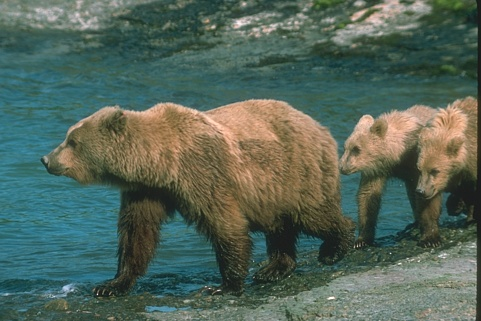

In [6]:
# Plot image from original dataset : sanity check
from IPython.display import Image, display
display(Image(filename=TRAIN_DATA_PATH + "train/100075.jpg"))

# Neural Network Model (CNN) for Regression


In [7]:
#Regression CNN network
class Color_Regression(nn.Module):
    def __init__(self,):
        super(Color_Regression, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv6_bn = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) 
        self.conv7_bn = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv8_bn = nn.BatchNorm2d(256)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv9_bn = nn.BatchNorm2d(256)

        self.tconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) 
        self.tconv1_bn = nn.BatchNorm2d(128)
        self.tconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.tconv2_bn = nn.BatchNorm2d(64)
        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.tconv3_bn = nn.BatchNorm2d(32)
        self.tconv4 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.conv7_bn(self.conv7(x))) 

        x = F.relu(self.conv8_bn(self.conv8(x)))
        x = F.relu(self.conv9_bn(self.conv9(x)))

        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = F.relu(self.tconv3_bn(self.tconv3(x)))
        x = self.tconv4(x)

        return x

In [8]:
model = Color_Regression()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

#compute the number of trainable parameters :
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: %d' % (num_params))

Number of trainable parameters: 3004610


### Training and Validation Loop

In [ ]:
#Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
#Loss function : L2 norm 
criterion = nn.MSELoss()

tr_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

start_time = time.time()

for epoch_nr in range(num_epochs):
     
    print("Epoch {}:".format(epoch_nr))
    running_loss = 0.0
    running_acc = 0.0
    
    #TRAINING :
    for i, (lab_batch) in enumerate(train_loader):
        
        lab_batch = lab_batch.to(device)
        
        # Color_Regression model prediction 
        # Input : luminescence L of the LAB images --> [batch_size, 1, H, W]
        # Output : AB predicted images --> [batch_size, 2, H, W]
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        
        # L2 error between  predicted AB color and actual AB color and
        loss = criterion(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
       
        running_loss += loss.item()
        
        
    #Print results 
    tr_loss = running_loss/len(train_loader.dataset)
    print('>> TRAIN: Epoch {} completed | tr_loss: {:.4f}'.format(epoch_nr, tr_loss))

    #VALIDATION : 
    running_acc = 0
    with torch.no_grad(): 
      for i, (lab_batch) in enumerate(val_loader):
        lab_batch = lab_batch.to(device)

        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

        loss = criterion(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        running_loss += loss.item()

    val_loss = running_loss/len(val_loader.dataset)
    print('>> VALIDATION: Epoch{} | val_loss: {:.4f}'.format(epoch_nr, val_loss))

    tr_losses[epoch_nr] = tr_loss
    val_losses[epoch_nr] = val_loss
    
# Save model
torch.save(model.state_dict(), './Color_Regression.pth')

end_time = time.time()
print('Finished Training in {:.2f} seconds'.format(end_time-start_time))

In [10]:
#Write training and validation loss in files :
tr_list = open("tr_loss_Berkeley_500epch_112.txt", "w")
for element in tr_losses:
    tr_list.write(str(element) + "\n")
tr_list.close()

val_list = open("val_loss_Berkeley_500epch_112.txt", "w")
for element in val_losses:
    val_list.write(str(element) + "\n")
val_list.close()

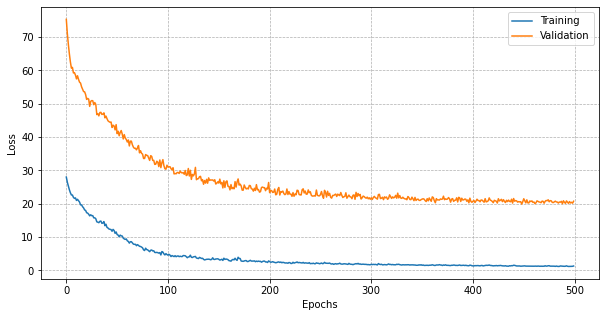

In [26]:
# Plotting Training and Validation losses :
fig = plt.figure(figsize=(10, 5))

plt.grid(which='major', linestyle='--', linewidth='0.7')
plt.plot(tr_losses, label = 'Training')
plt.plot(val_losses, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('losses_regression_Berkeley_500epchs_112.png', dpi = 200, bbox_inches='tight')
plt.show()

### Testing - Results : Plotting

In [9]:
# RUN ONLY IF YOU WANT TO LOAD AN EXISTING MODEL FROM SOME pth FILE

path_to_state_dict = "./Color_Regression_Berkeley_500epch_112.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = Color_Regression().to(device)
model.load_state_dict(torch.load(path_to_state_dict))

model.eval()

cuda


Color_Regression(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_bn): BatchNorm2d(128, eps=1e-05,

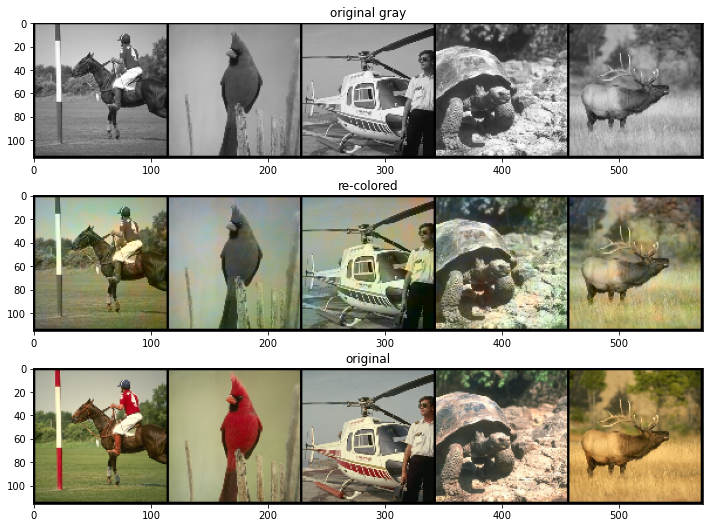

In [10]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # Take a random subset of images from the test_dataset
    
    image_inds = np.random.choice(len(test_dataset), 5, replace=False)
    lab_batch = torch.stack([test_dataset[i] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # Predict AB color based on gray input image
    predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()
    
    img_ab_zeros =  np.zeros((lab_batch.size(0), 2, size,size))
    img_ab_zeros = torch.from_numpy(img_ab_zeros)
    img_gray_abzeros = torch.cat([lab_batch[:, 0:1, :, :], img_ab_zeros], dim=1)
    img_gray_abzeros = img_gray_abzeros.cpu()

    # Converting AB images back to RGB color space
    rgb_batch = []
    predicted_rgb_batch = []
    img_gray_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))
        
        img_gray_rgb = color.lab2rgb(np.transpose(img_gray_abzeros[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        img_gray_rgb_batch.append(torch.FloatTensor(np.transpose(img_gray_rgb, (2, 0, 1))))

    # Plotting (re-colored VS ground truth)
    fig, ax = plt.subplots(figsize=(12, 9), nrows=3, ncols=1)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(img_gray_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('original gray')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('re-colored')
    ax[2].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[2].title.set_text('original')
    plt.show()